In [443]:
import numpy as np
import pandas as pd
from sklearn import metrics, cross_validation
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [503]:
### Reading data
data = pd.read_csv('../data/data.csv')
data.set_index('shot_id', inplace=True)
# The following should be explicitly made categorical as they are encoded using integers
data["action_type"] = data["action_type"].astype('object')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [507]:
# data cleaning
unknown_mask = data['shot_made_flag'].isnull()
data_cl = data.copy()
target = data_cl['shot_made_flag'].copy()
data_cl.drop('team_id', inplace=True, axis=1)  # only 1 category
data_cl.drop('lat', inplace=True, axis=1)  # correlated with loc_x
data_cl.drop('lon', inplace=True, axis=1)  # correlated with loc_y
data_cl.drop('game_id', inplace=True, axis=1)  # should not be dependent on game id
data_cl.drop('game_event_id', inplace=True, axis=1)  # independent, unique for every shots in a game
data_cl.drop('team_name', inplace=True, axis=1)  # always LA Lakers
data_cl.drop('shot_made_flag', inplace=True, axis=1)  # target variables
data_cl.drop('season', axis=1, inplace=True) # obtained a very good accuracy when season is dropped
data_cl.drop('shot_zone_range', axis=1, inplace=True) # obtained accuracy improvement after dropping season
data_cl.drop('combined_shot_type', axis=1, inplace=True) # obtained accuracy improvement after dropping game_month 
data_cl.drop('shot_type', axis=1, inplace=True) # obtained accuracy improvement after dropping combined_shot_type

In [508]:
# Game date -- extract year
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl.drop('game_date', axis=1, inplace=True)

In [509]:
#Extract time related features
data_cl['time_remaining'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_3_sec'] = data_cl['time_remaining'] < 3
data_cl['last_5_sec'] = data_cl['time_remaining'] < 5
data_cl['last_10_sec'] = data_cl['time_remaining'] < 10

# drop redundant features
data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('time_remaining', axis=1, inplace=True)

In [510]:
from sklearn import mixture
gaussianMixtureModel1 = mixture.GMM(n_components= 16, covariance_type='full', params='wmc', init_params='wmc',
                                    random_state=1, n_init=3,  verbose=0)
gaussianMixtureModel1.fit(data_cl.ix[:,['loc_x','loc_y']])
data_cl['shotLocationCluster'] = gaussianMixtureModel1.predict(data_cl.ix[:,['loc_x','loc_y']])

data_cl.drop('loc_x', axis=1, inplace=True)
data_cl.drop('loc_y', axis=1, inplace=True)

In [511]:
## Matchup -- (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

In [512]:
data_cl['first_period'] = data_cl['period'] == 1
data_cl['second_period'] = data_cl['period'] == 2
data_cl['third_period'] = data_cl['period'] == 3
data_cl['fourth_period'] = data_cl['period'] == 4
data_cl['final_period'] = data_cl['period'] > 4
data_cl.drop('period', axis=1, inplace=True)

In [513]:
# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [514]:
# Replace  least common action types with value 'rare'
rare_opponent = data_cl['opponent'].value_counts().sort_values().index.values[:30]
data_cl.loc[data_cl['opponent'].isin(rare_opponent), 'opponent'] = 'rare'

In [343]:
# One-hot encoding of categorical variables
categorial_cols = ['action_type','playoffs','shot_zone_area','shot_zone_basic', 'opponent', 'shotLocationCluster']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [344]:
# Train/validation split
# Separate dataset for validation
data_submit = data_cl[unknown_mask]
# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

In [345]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [492]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=110)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=110, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [493]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [494]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.94%


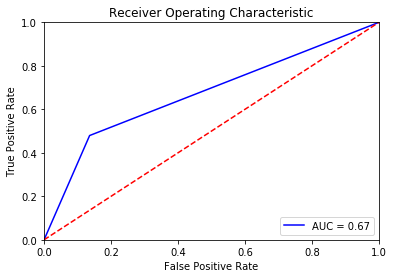

In [500]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()